In [1]:
import pandas as pd
import numpy as np
import collections as coll
import urllib as ulib
import datetime as date
from pprint import pprint
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def getData(startdt=[15,7,4], savepath='/Users/ash/ds/projects/data/mta/mta_turnstile_summer2015data.csv'):
    """takes in start dt as a list [yy,m,d] and savepath as a string ('path/<file.txt>'); saves a big CSV file to this path
    which can be read in as a giant pandas dataframe."""
    
    #create filename url list (summer 2015 start date is 15,7,4)
    startdt = date.date(startdt[0],startdt[1],startdt[2])
    uri = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"
    urllist = [re.sub("-","",uri+str(startdt + date.timedelta(days=i))[2:]+str('.txt')) for i in np.arange(0,90,7)]
    
    #urllist = ["http://web.mta.info/developers/data/nyct/turnstile/turnstile_150704.txt",
    #           "http://web.mta.info/developers/data/nyct/turnstile/turnstile_150711.txt",
    #           "http://web.mta.info/developers/data/nyct/turnstile/turnstile_150718.txt"]
    
    
    #download from first url with header
    response = ulib.urlopen(urllist[0])
    df = pd.read_csv(response, 
                     header=0)
    #dfbig = pd.DataFrame({})
    response.close()
    
    #download from remaining urls and concatenate without header to dataframe
    for url in urllist[1:]:
        response = ulib.urlopen(url)
        df = pd.concat([df,pd.read_csv(response, 
                                       skiprows=1,
                                       skip_blank_lines=True)])
        response.close()
    
    df.drop(df.columns[[0,1,2,3,4,5,6,7,8,9,10]],axis=1)

    #df = pd.concat([df,dfbig], axis=0)
    #'/Users/ash/ds/projects/data/mta/mta-turnstile-summer2015data.csv'
    pd.DataFrame.to_csv(df, savepath)
        
            
    
    

In [3]:
#getData()

In [251]:
%%time
#Prepare data
df1 = pd.read_csv('/Users/ash/ds/projects/data/mta/mta_turnstile_summer2015data.csv')
df1.drop(df1.columns[0],axis=1, inplace=True)
df1.rename(columns=lambda x: x.strip(), inplace=True)
df1['DATE'] = pd.to_datetime(df1['DATE'])
df1['WEEKDAY'] = pd.DatetimeIndex(df1['DATE']).weekday
df1['MONTH']=pd.DatetimeIndex(df1['DATE']).month
df1["INFLOW"]=df1.groupby(["C/A","UNIT","SCP","STATION","DATE"]).ENTRIES.diff()
df1["OUTFLOW"]=df1.groupby(["C/A","UNIT","SCP","STATION","DATE"]).EXITS.diff()
df1["FLUX"]=df1["INFLOW"]-df1["OUTFLOW"]
df2 = df1

CPU times: user 5min 11s, sys: 3.58 s, total: 5min 15s
Wall time: 5min 15s


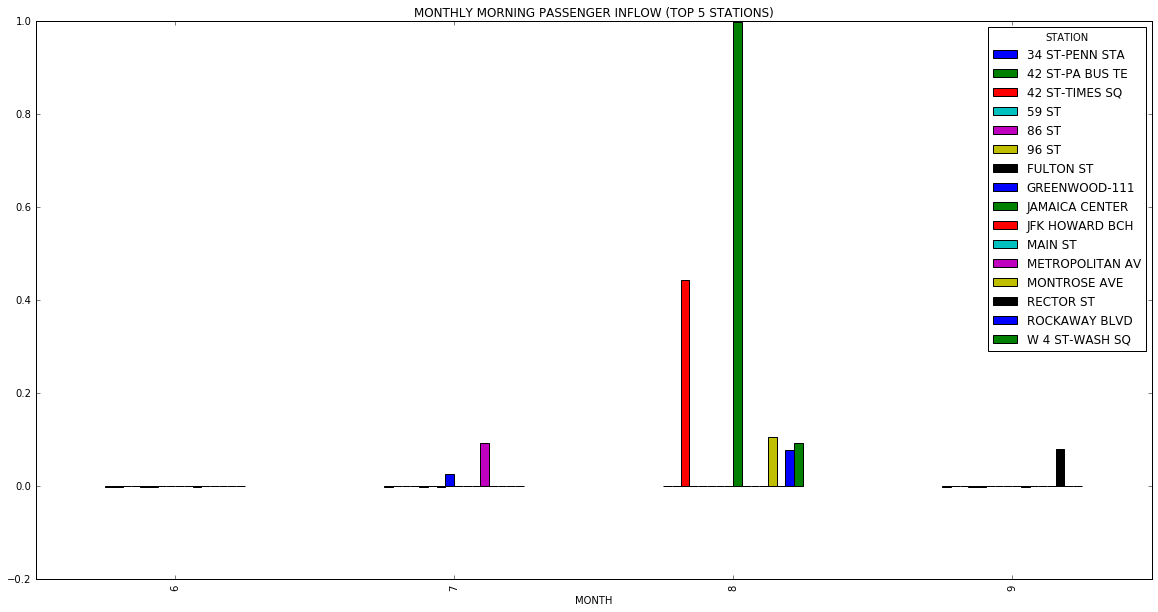

In [309]:
#PLOT: TOP 5 STATIONS IN THE MORNING WITH HIGHEST INFLOW (PEOPLE COMING IN)

monthmap = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}


df_morning_inflow = df2.loc[(df2["TIME"].isin(["08:00:00","13:00:00","09:00:00","12:00:00"]))&(df2.FLUX>0),["STATION","DATE","WEEKDAY","MONTH","INFLOW","OUTFLOW","FLUX"]]
#df_morning_inflow = df_morning_inflow.loc[(df_morning_inflow.FLUX<100000),:]
morning_grp=df_morning_inflow.groupby(['MONTH','STATION']).FLUX.sum()

df_morning=morning_grp.reset_index()
df_morning['FLUXscaled']=(df_morning.FLUX-df_morning.FLUX.mean())/float((df_morning.FLUX.max()-df_morning.FLUX.min()))
df_morning = df_morning.sort_values(['MONTH','FLUXscaled','STATION'], ascending=[True,False,True])
df_morning = df_morning.groupby('MONTH')
df_morning=df_morning.head(5)

(df_morning
 .pivot(index='MONTH',columns='STATION',values='FLUXscaled')
 .plot.bar(
        title='MONTHLY MORNING PASSENGER INFLOW (TOP 5 STATIONS)',
        figsize=(20,10))
)

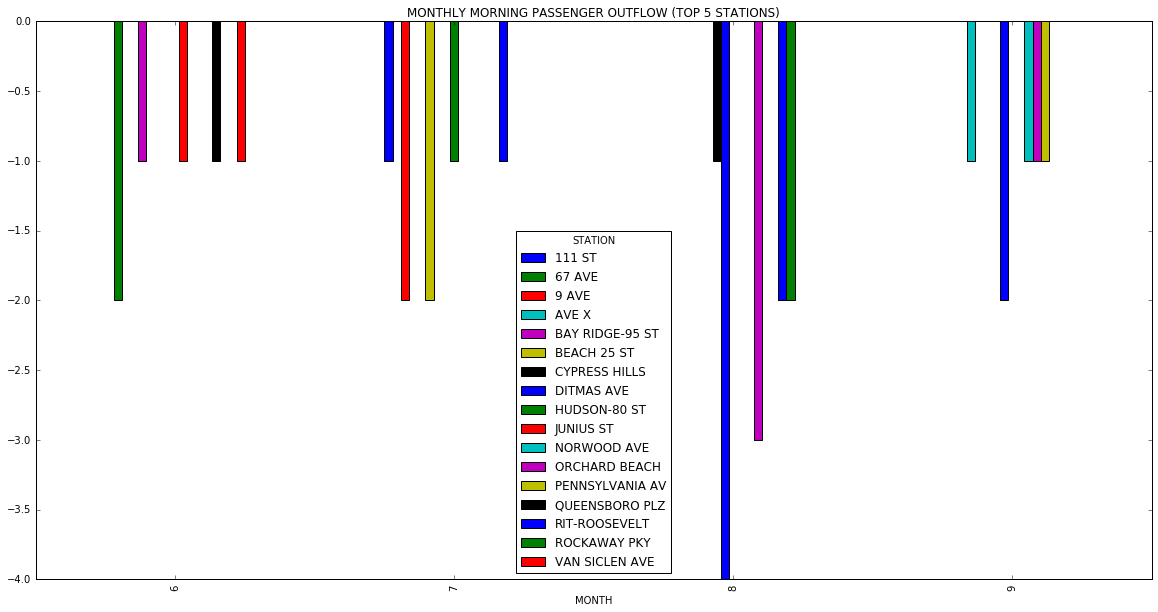

In [310]:
#PLOT: TOP 5 STATIONS IN THE MORNING WITH HIGHEST OUTFLOW (PEOPLE LEAVING)
df_morning_outflow = df2.loc[(df2["TIME"].isin(["08:00:00","13:00:00","09:00:00","12:00:00"]))&(df2.FLUX<0),["STATION","DATE","WEEKDAY","MONTH","INFLOW","OUTFLOW","FLUX"]]

#aggregate sums for morning
morning_grp=df_morning_outflow.groupby(['MONTH','STATION']).FLUX.sum()

df_morning_out=morning_grp.reset_index()
#df_morning['FLUXscaled']=(df_morning.FLUX-df_morning.FLUX.mean())/float((df_morning.FLUX.max()-df_morning.FLUX.min()))
df_morning_out = df_morning_out.sort_values(['MONTH','FLUX','STATION'], ascending=[True,False,True])
df_morning_out = df_morning_out.groupby('MONTH')
df_morning_out=df_morning_out.head(5)

(df_morning_out
 .pivot(index='MONTH',columns='STATION',values='FLUX')
 .plot.bar(
        title='MONTHLY MORNING PASSENGER OUTFLOW (TOP 5 STATIONS)',
        figsize=(20,10))
)

In [296]:
#COMBINE INFLOW AND OUTFLOW INTO ONE PLOT AREA

#plt.figure(figsize=(20,30))    #initiate the plot
#(df_morning_out
# .pivot(index='MONTH',columns='STATION',values='FLUX')
# .subplot.bar()
#)



AttributeError: 'DataFrame' object has no attribute 'subplot'